<a href="https://colab.research.google.com/github/adharangaonkar/Image-Processing-and-Computer-Vision/blob/main/Digit_Recognition/Image_Recognition_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import torch

In [101]:
from torch import nn
import torch.nn.functional as F

In [102]:
!pip3 install torchvision

  Using cached https://files.pythonhosted.org/packages/33/34/542152297dcc6c47a9dcb0685eac6d652d878ed3cea83bf2b23cb988e857/Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [103]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [104]:
transform= transforms.Compose([transforms.Resize([28, 28])
                               , transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root= './data', 
                                  train=True, download=True, transform= transform )
validation_dataset = datasets.MNIST(root= './data', 
                                  train=False, download=True, transform= transform )

In [105]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=[28, 28], interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [106]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size= 100, shuffle = 
                                            True)

In [107]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size= 100, shuffle = 
                                            False)

In [108]:
def im_convert(tensor):   # to convert the tensor into numpy arrays
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #d denormalize
  image = image.clip(0,1)
  return image

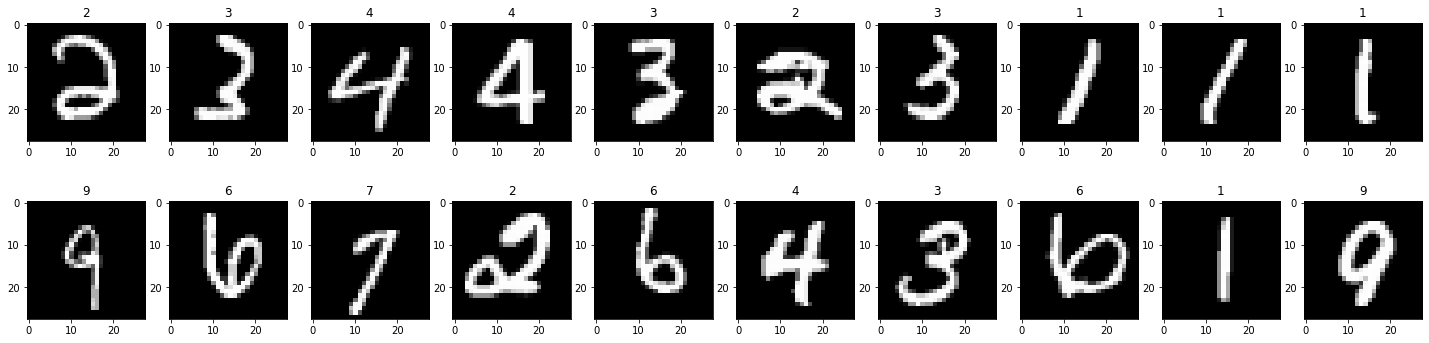

In [109]:
dataiter = iter(training_loader)
images, label = dataiter.next()
fig = plt.figure(figsize=(25,6))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(label[idx].item())

In [110]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  def forward(self, x):
    x = F.relu(self.linear1(x)) 
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x


In [111]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

In [113]:
images.shape

torch.Size([100, 1, 28, 28])

In [114]:
images.view(images.shape[0], -1).size()

torch.Size([100, 784])

In [115]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for i in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    # we will have to convert the image from size 1, 28,28 to a single row tensor 1, 784
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad(): # as there is no need for derivates in validation as no grads are to be updated
      for val_inputs, val_labels in validation_loader:
        # we will have to convert the image from size 1, 28,28 to a single row tensor 1, 784
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('Epoch:', i+1)
    print('Training Loss: {:.4f}, Training Accuracy{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('Validation  Loss: {:.4f}, Validation Accuracy{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


Epoch: 1
Training Loss: 0.9189, Training Accuracy79.3950
Validation  Loss: 0.4119, Validation Accuracy88.9800
Epoch: 2
Training Loss: 0.3763, Training Accuracy89.3933
Validation  Loss: 0.3254, Validation Accuracy90.3900
Epoch: 3
Training Loss: 0.3228, Training Accuracy90.5883
Validation  Loss: 0.2983, Validation Accuracy91.2900
Epoch: 4
Training Loss: 0.2923, Training Accuracy91.5117
Validation  Loss: 0.2669, Validation Accuracy92.5400
Epoch: 5
Training Loss: 0.2652, Training Accuracy92.3400
Validation  Loss: 0.2459, Validation Accuracy92.6600
Epoch: 6
Training Loss: 0.2422, Training Accuracy93.0583
Validation  Loss: 0.2257, Validation Accuracy93.5500
Epoch: 7
Training Loss: 0.2222, Training Accuracy93.6967
Validation  Loss: 0.2096, Validation Accuracy93.8500
Epoch: 8
Training Loss: 0.2059, Training Accuracy94.1483
Validation  Loss: 0.1966, Validation Accuracy94.3900
Epoch: 9
Training Loss: 0.1908, Training Accuracy94.4500
Validation  Loss: 0.1859, Validation Accuracy94.6000
Epoch: 10


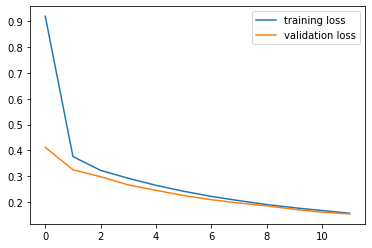

In [116]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

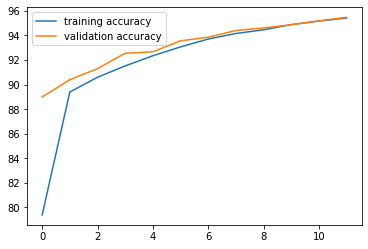

In [117]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## Testing our Model 

In [118]:
!pip3 install pillow==4.0

Processing /root/.cache/pip/wheels/4f/0a/2a/7e3391063af230fac4b5fdb4cc93adcb1d99af325b623cea03/Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl
ERROR: torchvision 0.9.1+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0


In [119]:
import requests
from PIL import Image
import PIL.ImageOps

In [120]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg' 
response = requests.get(url, stream = True)
print(response)

<Response [200]>


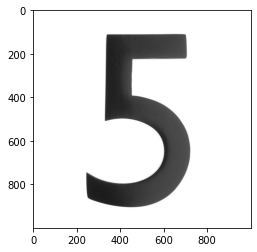

In [121]:
img = Image.open(response.raw)
plt.imshow(img)

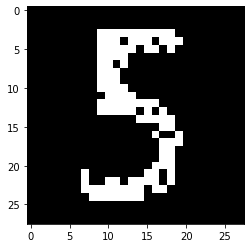

In [122]:
img = PIL.ImageOps.invert(img)
img = img.convert('1') 
img = transform(img)
plt.imshow(im_convert(img))

In [124]:
img = img.view(img.shape[0], -1)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(pred.item())

5


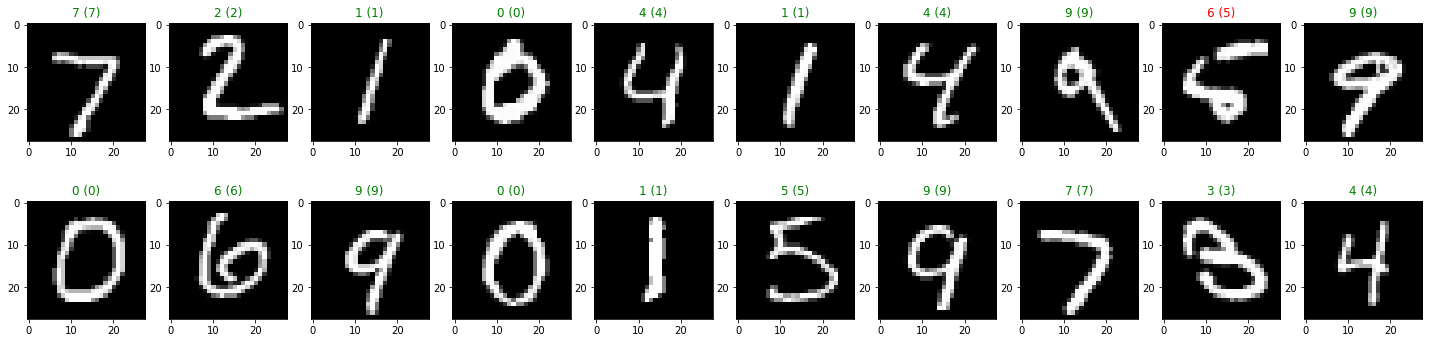

In [129]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
outputs = model(images_)
_, preds = torch.max(outputs, 1)
fig = plt.figure(figsize=(25,6))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
               color=("green" if preds[idx]==labels[idx] else "red"))